# PS 2 - John-Henry Pezzuto

## Packages & Data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.grid_search import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity
from sklearn.cross_validation import LeaveOneOut
import statsmodels.api as sm
from scipy.stats import gaussian_kde

bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 1a)

##### Set Up Axes

In [2]:
inc_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
ages = np.linspace(18,95,78)

##### Plot Graph

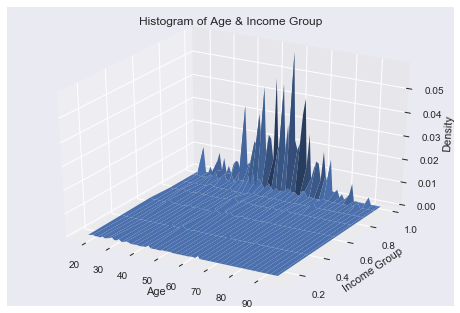

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y_mat, x_mat=np.meshgrid(inc_mdpts,ages)
ax.set_xlabel("Age")
ax.set_ylabel("Income Group")
ax.set_zlabel("Density")
ax.set_title("Histogram of Age & Income Group")
ax.plot_surface(x_mat,y_mat , bq_data)

### 1b)

In [4]:
# estimate bandwidth with leave one out cross val
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data[:, ]);

In [5]:
grid.best_params_
bandwidth = .1
print("The best badndwitdth is:", bandwidth)

The best badndwitdth is: 0.1


In [6]:
# prepare data
prop_mat_age = np.sum(bq_data, axis=1) 
prop_mat_inc = np.sum(bq_data, axis=0) 
sim = 70000 
age_probs = np.random.multinomial(sim, prop_mat_age)
income_probs = np.random.multinomial(sim, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

In [7]:
# frequency distribution of age values
for age, num_s in zip(ages, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)
age_freq.shape

(70000,)

In [8]:
# frequency distribution of ability types
for abil, num_j in zip(inc_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)
inc_freq.shape

(70000,)

In [9]:
# 2d array of age values and income group values
data = np.vstack((age_freq, inc_freq))
kernel_density = gaussian_kde(data, bw_method=bandwidth)
ages_mat, inc_mat = np.meshgrid(ages,inc_mdpts)


# flatten the grid values and fit it in the density estimator
coords = np.vstack([item.ravel() for item in [ages_mat, inc_mat]])
BQkde = kernel_density(coords).reshape(ages_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

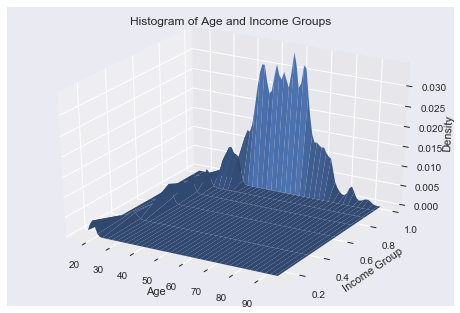

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(ages_mat, inc_mat, BQkde_scaled)
ax.set_xlabel("Age")
ax.set_ylabel("Income Group")
ax.set_zlabel("Density")
ax.set_title("Histogram of Age and Income Groups")
plt.show()

In [11]:
estimate = BQkde_scaled[5,43]

In [12]:
print("Estimated density for a recipient age 61 and 6th lifetime income category:", estimate)

Estimated density for a recipient age 61 and 6th lifetime income category: 7.69753350541e-07


## 2) Interaction Terms

In [13]:
biden = pd.read_csv("biden.csv")

##### a) Conditional on Education

In [14]:
X =  biden[['age', 'educ']]
y =  biden['biden']
X['age*educ'] = X['age']*X["educ"]
X['const'] = 1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
regression = sm.OLS(y, X, missing='drop', hasconst=True)

In [16]:
regression.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Sun, 29 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        22:42:20   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.6674      0.169      3.950      0.000       0.336       0.999
educ           1.7123      0.709      2.414      0.016       0.321       3.103
age*educ      -0.0477      0.013     -3.728      0.000      -0.073      -0.023
const         37.5491      9.491      3.956      0.000      18.935      56.163
==============================================================================
Omnibus:                       64.792   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.979
Skew:                          -0.480   Prob(JB):                     3.86e-16
Kurtosis:                       3.105   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The marginal effect of age is $\beta_1+\beta_3 X_2$, and the estimated effect is $0.67-0.048\times education$, with all coefficients significant at 0.01. Therefore, the effect of age on feelings towards Biden decreases with more education.

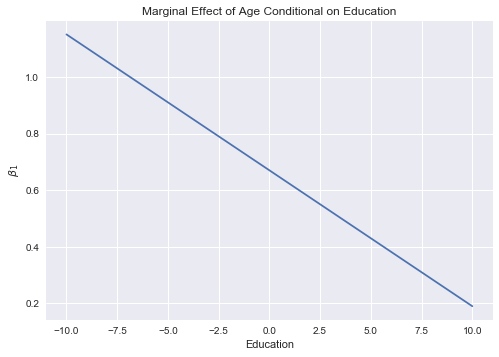

In [17]:
x = np.linspace(-10, 10, 1000)    
fig, ax = plt.subplots()
ax.plot(x, (0.67-0.048*x))
ax.grid(True, which='both')
ax.set_ylabel(r"$\beta_1$")
ax.set_xlabel("Education")
ax.set_title("Marginal Effect of Age Conditional on Education")
plt.show()

##### 2b) Conditional on Age

The marginal effect of education is $\beta_2+\beta_3 X_1$, and the estimated effect is $1.71-0.048\times age$, with all coefficients significant at 0.05. Therefore, the effect of education on feelings toward Biden also decreases with older age.

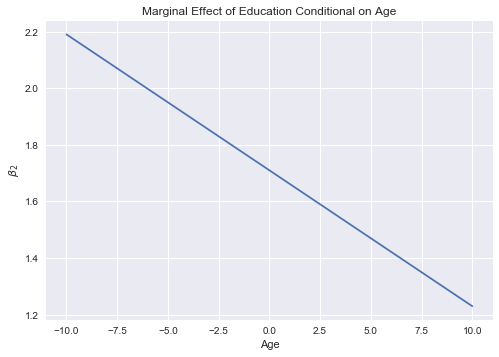

In [18]:
fig, ax = plt.subplots()
ax.plot(x, (1.71-0.048*x))
ax.grid(True, which='both')
ax.set_ylabel(r"$\beta_2$")
ax.set_xlabel("Age")
ax.set_title("Marginal Effect of Education Conditional on Age")
plt.show()